# Trainning of the RF 

In [2]:
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapely

json_path = "sdc-test-data.json"

In [3]:


@dataclass
class TestDetails:
    test_id: str
    hasFailed: bool
    sim_time: float
    road_points: list[tuple[float, float]]


def _curvature_profile(test_detail: TestDetails) -> list[float]:
    """
    Compute the curvature for every meter of the road.

    The following website was used as a reference: https://de.wikipedia.org/wiki/Kr%C3%BCmmung
    """
    #print("compute curvature profile")
    road_shape = shapely.LineString(test_detail.road_points)

    delta_s = 2  # 10 meters

    curvature_profile = np.zeros(int(road_shape.length)) # we want the curvature for every meter
    for s in range(len(curvature_profile)):
        #s = (i+1)*delta_s

        # ignore the edge cases close to the ends of the road
        if (s < delta_s/2) or (s > road_shape.length-delta_s/2):
            continue


        pt_q: shapely.Point = road_shape.interpolate(s-delta_s, normalized=False)
        pt_r: shapely.Point = road_shape.interpolate(s-delta_s/2, normalized=False)

        pt_s: shapely.Point = road_shape.interpolate(s, normalized=False)

        pt_t: shapely.Point = road_shape.interpolate(s+delta_s/2, normalized=False)
        pt_u: shapely.Point = road_shape.interpolate(s+delta_s, normalized=False)

        tangent_r_vec = np.array((pt_s.x-pt_q.x, pt_s.y-pt_q.y))
        tangent_t_vec = np.array((pt_u.x-pt_s.x, pt_u.y-pt_s.y))

        cos_phi = np.dot(tangent_r_vec, tangent_t_vec)/(np.linalg.norm(tangent_r_vec)*np.linalg.norm(tangent_t_vec))
        phi = np.arccos(cos_phi)

        kappa = phi/delta_s
        if np.isnan(kappa):
            continue

        curvature_profile[s] = kappa

    return curvature_profile

## NEW FUNCTION

In [5]:
def Radius_metric(radius: np.ndarray) -> dict:
    return radius[np.isfinite(radius)]


def _distance_profile(test_detail: TestDetails) -> list[float]:
    """
    Compute the cumulative distance along the road at each meter.

    This function returns the distance from the start of the road for each sampled point.
    """
    road_shape = shapely.LineString(test_detail.road_points)

    delta_s = 1  # Resolution to compute I put 1 meter to be more flexible 
    total_length = int(road_shape.length)

    distance_profile = np.zeros(total_length)

    for s in range(total_length):
        if s < 0 or s > road_shape.length:
            continue

        pt: shapely.Point = road_shape.interpolate(s, normalized=False)
        distance_profile[s] = s 

    return distance_profile



def build_feature_df(tests: List[TestDetails]):
    rows = []
    seuil = 1e-9
    for t in tests:
        kappa = np.asarray(_curvature_profile(t), dtype=float)
        radius = Radius_metric(kappa)
        dist = np.asarray(_distance_profile(t), dtype=float)
        rows.append({
            "test_id": t.test_id,
            "hasFailed": int(bool(t.hasFailed)),
            "sim_time": float(t.sim_time) if t.sim_time == t.sim_time else np.nan,
            ("curvature_mean", "curvature_std"): (np.mean(kappa), np.std(kappa)) , 
            ("dist_mean", "dist_std"): (np.mean(dist), np.mean(dist)) , 
            ("Radius_mean", "Radius_std"): (np.std(radius), np.std(radius))
        })
    return pd.DataFrame(rows)




In [6]:

df = pd.read_json(json_path)


if "meta_data" in df.columns:
    meta_df = pd.json_normalize(df["meta_data"])
    df_flat = pd.concat([meta_df, df["road_points"]], axis=1)
else:
    df_flat = df.copy()

# Colonnes
label_col = "test_info.test_outcome"        
id_col    = "test_info.test_id"            
sim_col   = "test_info.test_duration"                     

tests: List[TestDetails] = []
for i, row in df_flat.iterrows():
    pts_raw = row["road_points"]
    pts = [(p["x"], p["y"]) for p in pts_raw] if isinstance(pts_raw, list) else []


    # BLABLA BLA  this for becoming a dataclass
    test_id = str(row[id_col]) if id_col in df_flat.columns and pd.notna(row[id_col]) else f"test_{i}"
    outcome = str(row[label_col]) if label_col in df_flat.columns and pd.notna(row[label_col]) else "PASS"
    hasFailed = (outcome.upper() == "FAIL")
    sim_time = float(row[sim_col]) if sim_col in df_flat.columns and pd.notna(row[sim_col]) else np.nan

    tests.append(TestDetails(test_id=test_id, hasFailed=hasFailed, sim_time=sim_time, road_points=pts))

df_features = build_feature_df(tests)



In [7]:
curvature_mean = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[0])
curvature_std = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[1])


radius_mean = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[0])
radius_std = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[1])


dist_mean = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[0])
dist_std = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[1])

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report



In [9]:
X = dist_mean
y = radius_mean
z = curvature_mean 
name = "RF_model_3M"
target =  df_features["hasFailed"]
# PERMIT TO CHANGE QUIKLY OUR CODE TO HAVE THINGS TRAIN MULTIPLE MODEL TO FIND THE RIGHT METRIC MAX USE 3 METRIC I DIDN T PUT MORE BECAUSE I DIDN T SEE THE NECESSITY GIVEN THAT I ONLY HAVE 3 function ready 
def is_nan_array(arr):
    return arr is None or np.all(np.isnan(arr))

if is_nan_array(y) and is_nan_array(z):
    X_features = pd.DataFrame({'dist_mean': X})
elif is_nan_array(z):
    X_features = pd.DataFrame({'dist_mean': X, 'dist_std': y})
else:
    X_features = pd.DataFrame({'dist_mean': X, 'dist_std': y, 'curvature_mean': z})


# USE THE SAME TRAINNING SIZE AND TEST SIZE AS THE SDC SCISSOR 
X_tr, X_te, y_tr, y_te = train_test_split(
    X_features, target, test_size=0.2, stratify=target, random_state=0
)

#
classes = np.unique(y_tr)
cls_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
cw = {int(c): float(w) for c, w in zip(classes, cls_weights)}
print("Class weights:", cw)

# TAIN RANDOM FOREST 
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=0,
    class_weight=cw
)
rf.fit(X_tr, y_tr)


y_pred = rf.predict(X_te)
y_proba = rf.predict_proba(X_te)[:, 1]

# Évaluation
acc = accuracy_score(y_te, y_pred)
f1 = f1_score(y_te, y_pred)
auc = roc_auc_score(y_te, y_proba)

print(f"Accuracy: {acc:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
print(classification_report(y_te, y_pred, digits=3))


Class weights: {0: 0.7925311203319502, 1: 1.3546099290780143}
Accuracy: 0.646 | F1: 0.500 | AUC: 0.697
              precision    recall  f1-score   support

           0      0.709     0.744     0.726       121
           1      0.523     0.479     0.500        71

    accuracy                          0.646       192
   macro avg      0.616     0.611     0.613       192
weighted avg      0.640     0.646     0.642       192



In [10]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred, labels=["PASS", "FAIL"]):
    """

    Parameters:
    - y_true : array-like, valeurs réelles
    - y_pred : array-like, valeurs prédites
    - labels : list, noms des classes (par défaut ["PASS", "FAIL"])
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        ylabel='Truth',
        xlabel='Prediction',
        title='Confusion Matrix'
    )

    thresh = cm.max() / 2.0 if cm.size else 0.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


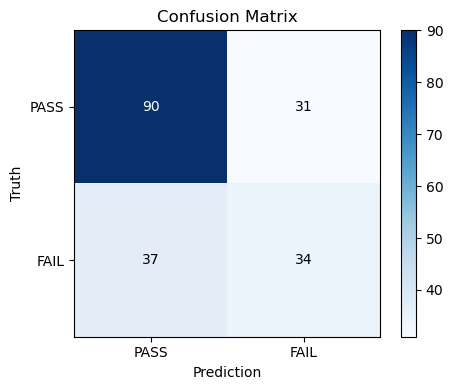

In [11]:
cm = plot_confusion_matrix(y_te, y_pred)  


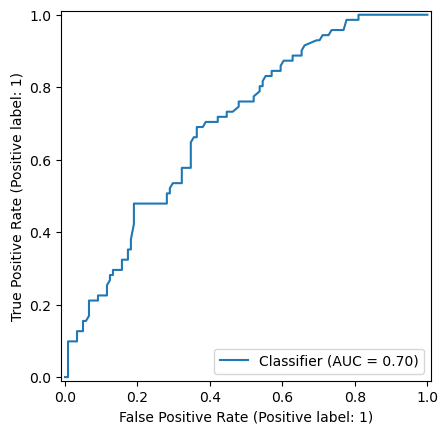

In [12]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_te, y_proba)
plt.show()


In [13]:
import joblib

joblib.dump(rf, f"./../{name}.joblib")

['./../RF_model_3M.joblib']

1 metric only curvature
2 metric cuvature + distance

# FUNCTION TO SIMPLIFICATE MY TRAINING PROGRAMME 

In [16]:
def PrefunctionTraining (json_path) : 
    df = pd.read_json(json_path)
    
    
    if "meta_data" in df.columns:
        meta_df = pd.json_normalize(df["meta_data"])
        df_flat = pd.concat([meta_df, df["road_points"]], axis=1)
    else:
        df_flat = df.copy()
    
    # Colonnes
    label_col = "test_info.test_outcome"        
    id_col    = "test_info.test_id"            
    sim_col   = "test_info.test_duration"                     
    
    tests: List[TestDetails] = []
    for i, row in df_flat.iterrows():
        pts_raw = row["road_points"]
        pts = [(p["x"], p["y"]) for p in pts_raw] if isinstance(pts_raw, list) else []
    
    
        # BLABLA BLA  this for becoming a dataclass
        test_id = str(row[id_col]) if id_col in df_flat.columns and pd.notna(row[id_col]) else f"test_{i}"
        outcome = str(row[label_col]) if label_col in df_flat.columns and pd.notna(row[label_col]) else "PASS"
        hasFailed = (outcome.upper() == "FAIL")
        sim_time = float(row[sim_col]) if sim_col in df_flat.columns and pd.notna(row[sim_col]) else np.nan
    
        tests.append(TestDetails(test_id=test_id, hasFailed=hasFailed, sim_time=sim_time, road_points=pts))
    
    df_features = build_feature_df(tests)
    return df_features


def TRAINING(df_features,x,y,z,name) : 
    target =  df_features["hasFailed"]
    # PERMIT TO CHANGE QUIKLY OUR CODE TO HAVE THINGS TRAIN MULTIPLE MODEL TO FIND THE RIGHT METRIC MAX USE 3 METRIC I DIDN T PUT MORE BECAUSE I DIDN T SEE THE NECESSITY GIVEN THAT I ONLY HAVE 3 function ready 
    def is_nan_array(arr):
        return arr is None or np.all(np.isnan(arr))
    
    if is_nan_array(y) and is_nan_array(z):
        X_features = pd.DataFrame({'dist_mean': X})
    elif is_nan_array(z):
        X_features = pd.DataFrame({'dist_mean': X, 'dist_std': y})
    else:
        X_features = pd.DataFrame({'dist_mean': X, 'dist_std': y, 'curvature_mean': z})
    
    
    # USE THE SAME TRAINNING SIZE AND TEST SIZE AS THE SDC SCISSOR 
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_features, target, test_size=0.2, stratify=target, random_state=0
    )
    
    #
    classes = np.unique(y_tr)
    cls_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
    cw = {int(c): float(w) for c, w in zip(classes, cls_weights)}
    print("Class weights:", cw)
    
    # TAIN RANDOM FOREST 
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=0,
        class_weight=cw
    )
    rf.fit(X_tr, y_tr)
    
    
    y_pred = rf.predict(X_te)
    y_proba = rf.predict_proba(X_te)[:, 1]
    
    # Évaluation
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    auc = roc_auc_score(y_te, y_proba)
    
    print(f"Accuracy: {acc:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    print(classification_report(y_te, y_pred, digits=3))
    cm = plot_confusion_matrix(y_te, y_pred)  
    RocCurveDisplay.from_predictions(y_te, y_proba)
    plt.show()
    joblib.dump(rf, f"./../{name}.joblib")



Class weights: {0: 0.7925311203319502, 1: 1.3546099290780143}
Accuracy: 0.625 | F1: 0.471 | AUC: 0.665
              precision    recall  f1-score   support

           0      0.693     0.727     0.710       121
           1      0.492     0.451     0.471        71

    accuracy                          0.625       192
   macro avg      0.593     0.589     0.590       192
weighted avg      0.619     0.625     0.621       192



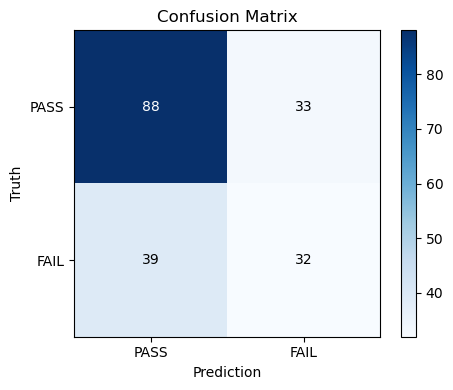

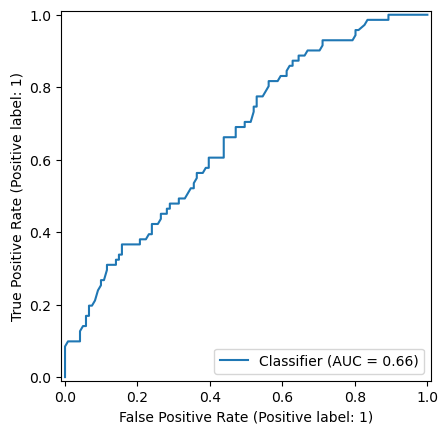

In [17]:
df_features = PrefunctionTraining (json_path)
curvature_mean = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[0])
curvature_std = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[1])


radius_mean = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[0])
radius_std = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[1])


dist_mean = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[0])
dist_std = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[1])


X = dist_mean
Y = radius_mean
Z = None 
name = "RF_model_2M"
TRAINING(df_features,X,Y,Z,name)

Class weights: {0: 0.7925311203319502, 1: 1.3546099290780143}
Accuracy: 0.490 | F1: 0.300 | AUC: 0.445
              precision    recall  f1-score   support

           0      0.593     0.603     0.598       121
           1      0.304     0.296     0.300        71

    accuracy                          0.490       192
   macro avg      0.449     0.450     0.449       192
weighted avg      0.487     0.490     0.488       192



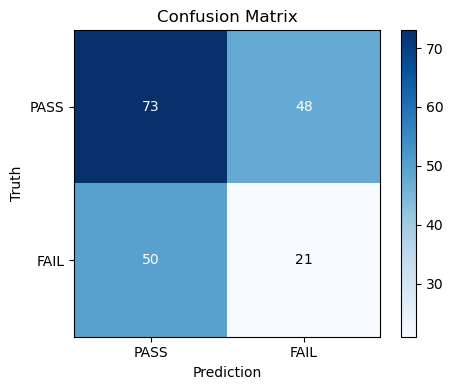

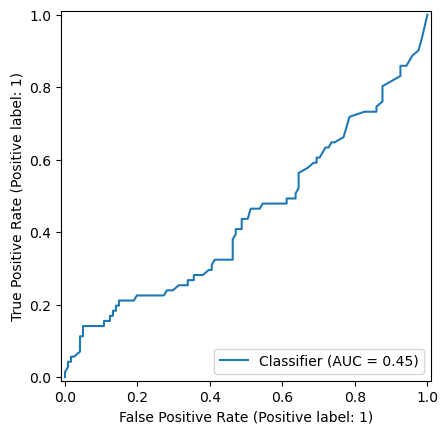

In [18]:
df_features = PrefunctionTraining (json_path)
curvature_mean = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[0])
curvature_std = df_features[("curvature_mean", "curvature_std")].apply(lambda x: x[1])


radius_mean = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[0])
radius_std = df_features[("Radius_mean", "Radius_std")].apply(lambda x: x[1])


dist_mean = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[0])
dist_std = df_features[ ("dist_mean", "dist_std")].apply(lambda x: x[1])


X = radius_mean
Y = None
Z = None 
name = "RF_model_1M"
TRAINING(df_features,X,Y,Z,name)